In [1]:
import sys
sys.path.append('..')
from Final_Models import Final_Net
from Transformer_Net import Prot_Transformer
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os 

In [12]:
network = Final_Net(2, 36, 50, 5,5, 16).to('cuda')
network.load_state_dict(torch.load('../../Contact_Model_Training/Training_Checkpoints/Model_98.pt'))
network.eval()

features = torch.tensor(torch.load('CASP14_Data/MSA_tensors/T1090_MSA.pt'))
dist_mat = torch.load('CASP14_Data/distance_matrices/T1090_distmat.pt')
features = torch.nn.functional.one_hot(features[None], num_classes=22).float().permute(0,2, 1,3)


#print(dist_mat[48:57, 65:75])
#print(dist_mat[0:10, 24:33])
#out = torch.bucketize(dist_mat, torch.arange(0,65)/64*20 +2)



out = torch.bucketize(dist_mat, torch.tensor([2,8]))

out = out[:]
out -= 1
out[out == -1] = 0
out = 1 - out

features = features[:,:, :300]
features.shape
#out = torch.nn.functional.one_hot(out)


torch.Size([1, 189, 233, 22])

In [13]:
def func(x):
    rslt = x.split('_')[0]
    if '-' in rslt:
        return rslt
    
    return rslt+'-D1'


a = set(pd.read_csv('CASP14_Results/L_FL.txt', delim_whitespace=True, skiprows=8).Domain)
b = set([func(i) for i in os.listdir('CASP14_Data/MSA_tensors/')])

len(a.intersection(b))

20

In [37]:
results = pd.DataFrame()



mask = torch.ones_like(out)

torch.diagonal(mask,offset=0).fill_(0)
for j in range(12):
    torch.diagonal(mask,offset=j).fill_(0)
    torch.diagonal(mask,offset=-j).fill_(0)
    
#print(torch.nonzero((out*mask) ==1))
print((out*mask).sum())

with torch.no_grad():
    preds, _, _ = network(features.to('cuda'), mask=None)
    
preds = preds.to('cpu')
preds = torch.softmax(preds[0,:], dim=0).cpu()
pred = preds[0] 


pred = pred + pred.T
pred = pred*mask

mean = pred[mask ==1].mean()
std = pred[mask ==1].std()


pred = pred
#print(mean)
#print(pred[(mask*out) == 1].mean())
#print(dist_mat[15:24, 90:98])
#print(pred[15:24, 90:98])
#print(pred[mask != 0].mean())
#print(torch.nonzero(pred > 0.14))

#print((pred >= 0.15).sum())


pred_cont = torch.zeros_like(pred)
v, i = torch.topk((pred).flatten(), (features.shape[1]*2 + 2)//5)
pred_cont[torch.tensor(np.unravel_index(i.numpy(), pred.shape)).T] = 1

x = ((((pred_cont) * (out))*mask).sum() / ((out)*mask).sum()).item()
y =  ((((pred_cont) * (out))*mask).sum() / ((pred_cont)*mask).sum()).item()
if x == 0 and y == 0:
    f1 = None
else:
    f1 = 2*(x*y)/(x+y)



pred_cont = (pred >= 0.5).long()

x = ((((pred_cont) * (out))*mask).sum() / ((out)*mask).sum()).item()
y =  ((((pred_cont) * (out))*mask).sum() / ((pred_cont)*mask).sum()).item()
if x == 0 and y == 0:
    f1 = None
else:
    f1 = 2*(x*y)/(x+y)
    

tensor(644)


In [38]:
from sklearn.metrics import average_precision_score

average_precision_score(out.flatten(), pred.flatten())

0.07837601081606138

In [39]:
f1

0.05716554028440031

In [4]:
import matplotlib.pyplot as plt

results[['f1']].plot()
results[['Recall']].plot()
results[['Presicion']].plot()

KeyError: "None of [Index(['f1'], dtype='object')] are in the [columns]"

ValueError: x and y must have same first dimension, but have shapes torch.Size([17]) and torch.Size([2])

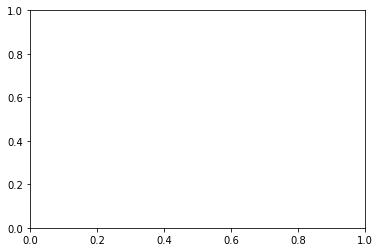

In [94]:
import matplotlib.pyplot as plt



for i in range(0, 40, 5):
    xcoor = 10
    ycoor = i
    
    #if i == 40:
    #    continue

    plt.plot(torch.arange(0,17)/16*22 + 2, preds[:,xcoor,ycoor], label=i)

    #plt.scatter(torch.arange(0,65), out[xcoor,ycoor, :]/50)
    
    #plt.axvline(x = dist_mat[xcoor,ycoor], c='red')
    
plt.legend()

In [16]:
import matplotlib.pyplot as plt

for i in range(1):
    xcoor = 20
    ycoor = i

    plt.plot(torch.arange(0,64)/64*20 +2, preds[0,:,xcoor,ycoor])
    plt.axvline(x = dist_mat[xcoor,ycoor], c='red')

IndexError: too many indices for tensor of dimension 3